## Designing the data warehouse

We have seen how to transfer data to a table via the use of Integration pipelines in Azure Synapse.

A very simple example when it comes to storing data in a data warehouse.
But there is a design strategy that is followed when designing tables in a data warehouse.

Just looking back as the usage of a SQL database as a backend for an application.

Now normally the application would add data to a table via the use of the INSERT SQL statement.
Here a row of data would be added to a table in the database.

But in a data warehouse things work a little differently.

Remember here data is used for analytical purposes.

Normally you don't insert rows of data one by one.

Instead you add and delete rows of data in bulk. This is because of the huge amount of data that is stored in the data warehouse.

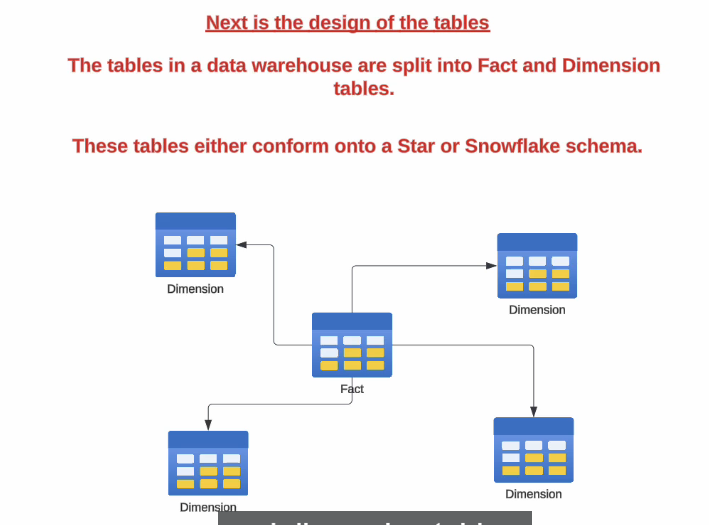

Snowflake Schema

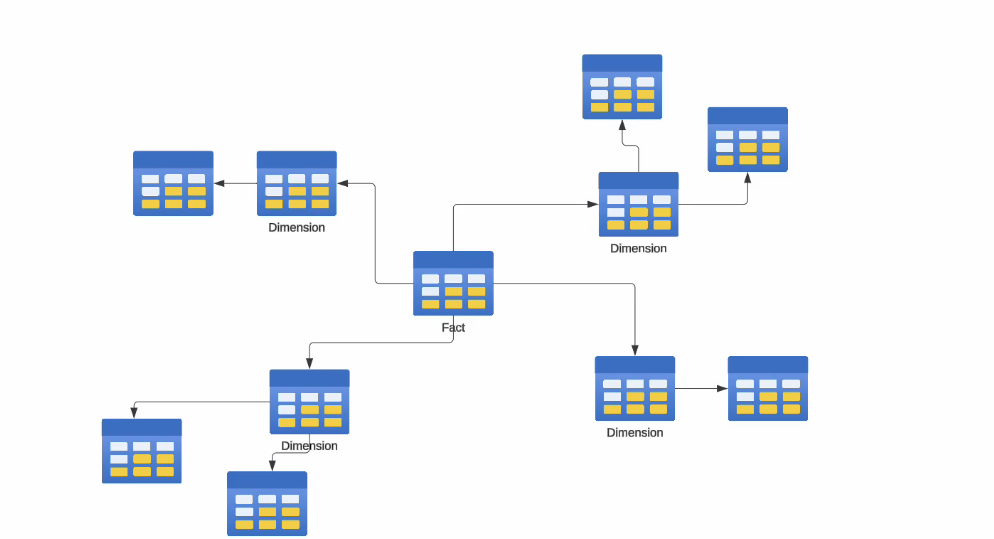

### FACT TABLE

A Fact Table is meant to store quantative data, that is data that can be measured

So let's say that users are making purchases via an ecommerce platform.
The sales data for varios products are being recorded in the
OLTP SQL database.


Now the sales being recorded are quantitative in nature. You can take the data over time and store in a Fact-based table in the data warehouse.

### Dimension Table

Dimension tables are used to used to present some context to the facts.

For example, based on the sales being made, you want to analyze what are the best selling products - Hence the product-related information would become a dimension.

This is because the product information is giving you a view or insight into the sales data.
Or you want to look at the top regions where sales are being made based on the customer's location. So the customer's information can be another dimension to give some more context to the sales.

In this way, we can construct our Fact and Dimension tables.

#### Note

In sql data ware house there is nothing forign key or primary key . we manage this using joins.
also there is no thing called normalization. we can google add more things

While connecting Power Bi to database we need to give Dedicated SQL Endpoint to connect the database
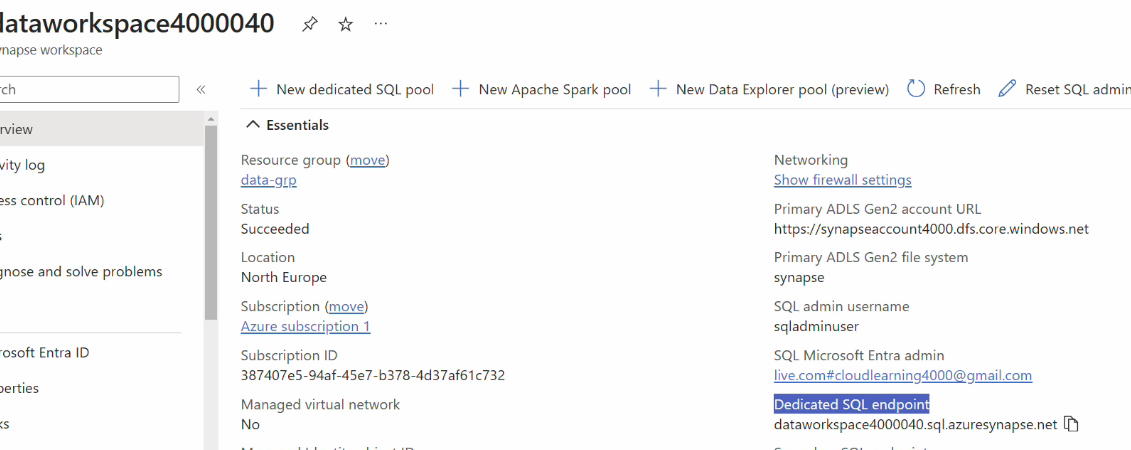

### Synapse SQL Architecture

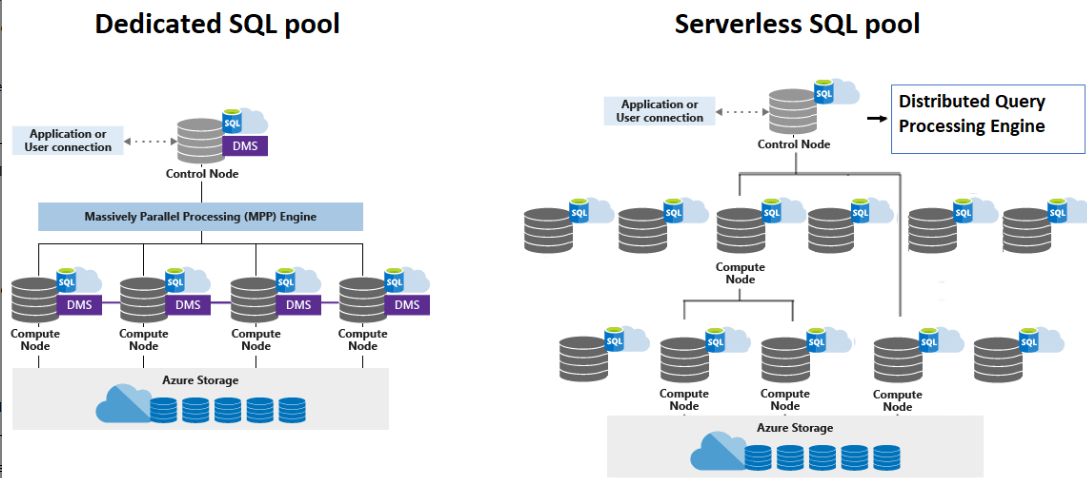

In Synapse SQL, the compute and storage are seperate so that each can be scaled seperately.

In the dedicated SQL pool , the compute power allocated to the pool is determined by a unit known as the data warehouse unit.
All queries are targeted towards the Control Node. And then the Control Node distributes the query for parallel processing across
the compute nodes.


So if you have 60 compute nodes , then you query will be split into 60 small queries and run in parallel.

All user data in Synapse SQL is stored in Azure Storage.

In Synapse SQL , the data in the dedicated SQL pool is sharded into distributions.


When you create a table in Azure Synapse, the data in the table is stored across 60 distributions - Round-Robin and Hash.

### Hash-distributed tables

Here the dedicated SQL pool used a hash function to decide to
which distribution to assign the row to.

As part of the table definition, you decide which column should
be used as the distribution column.

This is ideal for your fact tables.

### Round-Robin distributed tables

Here the data is evenly distributed across all distributions.

This type of table is effective when you need to load data into
staging tables. It provides a fast way to load data.

### Replicated Tables

Here each compute node would cache a full copy of the table.

This is ideal for dimension tables. When you perform JOINS for
your fact and dimension tables, if you have multiple compute
nodes, there is a Data Movement service that ensures that data is
avaiable on the compute node to fulfil the query operation.

#### Choose distribution column for Hash distribution

For best performance, all of the distributions should have approximately the same number of rows. When one or more distributions have a disproportionate number of rows, some distributions finish their portion of a parallel query before others. Since the query can't complete until all distributions have finished processing, each query is only as fast as the slowest distribution.

Data skew means the data is not distributed evenly across the distributions
Processing skew means that some distributions take longer than others when running parallel queries. This can happen when the data is skewed

To balance the parallel processing, select a distribution column or set of columns that for has distribution :

1. Has many unique values. 

2. Does not have NULLs, or has only a few NULLs. 

3. Is not a date column.


Choosing a distribution column or column set that helps minimize data movement is one of the most important strategies for optimizing performance of your dedicated SQL pool.

To minimize data movement, select a distribution column or set of columns that:

- Is used in JOIN, GROUP BY, DISTINCT, OVER, and HAVING clauses. When two large fact tables have frequent joins, query performance improves when you distribute both tables on one of the join columns. When a table is not used in joins, consider distributing the table on a column or column set that is frequently in the GROUP BY clause.

- Is not used in WHERE clauses. When a query's WHERE clause and the table's distribution columns are on the same column, the query could encounter high data skew, leading to processing load falling on only few distributions. This impacts query performance, ideally many distributions share the processing load.

- Is not a date column.


### Surrogate Key

Now sometimes for your dimension table, you will want to have a column that helps to uniquely identify the
rows in the dimension table.

Here ProductID refers to the Business Key because this is taken from the source.

Sometimes data can be taken from multiple sources and they have the same ProductID. Hence we will not
use this as the key to uniquely identify each row in the table.

We can define a surrogate key for the table. This could be a simple incrementing number.

CREATE TABLE dimProduct
(
    ProductSK INT IDENTITY(1,1) NOT NULL,
    ProductID int NOT NULL,
    ProductNumber varchar(100) NOT NULL,
    Color varchar(20) NOT NULL,
    ProductCategoryID int NOT NULL,
    ProductCategoryName varchar(200) NOT NULL
)
WITH
(
    DISTRIBUTION = REPLICATE
);


In this Identity doesn't mean it will start by 1 and increment . it is just an unique number


### Indexes on dedicated SQL pool

1. Clustered columnstore indexes

    By default, dedicated SQL pool creates a clustered columnstore index when no index options are specified on a table. Clustered columnstore tables offer both the highest level of data compression and the best overall query performance

    CREATE TABLE myTable
    (  
        id int NOT NULL,  
        lastName varchar(20),  
        zipCode varchar(6)  
    )  
    WITH ( CLUSTERED COLUMNSTORE INDEX );

    There are a few scenarios where clustered columnstore may not be a good option:

    Columnstore tables do not support varchar(max), nvarchar(max), and varbinary(max). Consider heap or clustered index instead.
    Columnstore tables may be less efficient for transient data. The transient data when data is taken from table and done some transformation .Consider heap and perhaps even temporary tables.
    Small tables with less than 60 million rows. Consider heap tables.

2. Heap tables 
    
    Heap table makes the overall process faster. this is used when transformation need to be done.this is used in staging area before moving data to prod.

    CREATE TABLE myTable
    (  
        id int NOT NULL,  
        lastName varchar(20),  
        zipCode varchar(6)  
    )  
    WITH ( HEAP );

3. Clustered and nonclustered indexes

    when a single row needs to be quickly retrieved. For queries where a single or very few row lookup is required to perform with extreme speed, consider a clustered index or nonclustered secondary index.

    CREATE TABLE myTable
    (  
        id int NOT NULL,  
        lastName varchar(20),  
        zipCode varchar(6)  
    )  
    WITH ( CLUSTERED INDEX (id) );

### Copy command vs Polybase vs Bulk Insert

The Bulk Insert method is slower than the Copy command or Polybase

Polybase gives you better performance when you are loading large amounts of data

With Bulk Insert all of the commands go through the Control Node

You can use the Bulk insert command when you have less data to transfer.

With Polybase, your data movement operations go
through the compute nodes in parallel. This gives better
loading times. And if you have more compute nodes, the
data loading process becomes faster.

Polybase also remember allows you to create
EXTERNAL tables. And then you can import data into
the dedicated SQL pool, creating tables using the
CREATE TABLE AS SELECT command.

Even the COPY command has high throughput and
goes through the compute nodes in the dedicated SQL
pool.

The COPY command is simple to execute, you don't need to define the EXTERNAL DATA SOURCE,

In Azure Synapse, while both PolyBase and the "COPY" command are used to load data from external sources like Azure Storage, PolyBase requires creating external tables to access data from external sources, whereas the "COPY" command is a more direct way to load data without the need for additional table definitions, making it often simpler to use for basic data ingestion, but PolyBase can be more flexible for complex scenarios where querying data directly from external sources is needed. 

#### When to use PolyBase:
When you need to frequently query large datasets stored in external sources without physically moving the data into Synapse.
When you want to join data from multiple external sources with data within your Synapse database. 

#### When to use the "COPY" command:
For straightforward data loading from external storage to Synapse without complex data manipulation.
When you want a simpler approach with less setup required for data ingestion

## Partitioning

Table partitions enable you to divide your data into smaller groups of data. In most cases, table partitions are created on a date column. Partitioning is supported on all dedicated SQL pool table types; including clustered columnstore, clustered index, and heap. Partitioning is also supported on all distribution types.

In most cases data is partitioned on a date column that is closely tied to the order in which the data is loaded into the SQL pool.

Partition switching can be used to quickly remove or replace a section of a table

For example, a sales fact table might contain just data for the past 36 months. At the end of every month, the oldest month of sales data is deleted from the table. This data could be deleted by using a delete statement to delete the data for the oldest month.

A more optimal approach is to drop the oldest partition of data. Where deleting the individual rows could take hours, deleting an entire partition could take seconds.

#### Partition sizing
While partitioning can be used to improve performance some scenarios, creating a table with too many partitions can hurt performance under some circumstances.

 For optimal compression and performance of clustered columnstore tables, a minimum of 1 million rows per distribution and partition is needed. Before partitions are created, dedicated SQL pool already divides each table into 60 distributions.

File names or folders that begin with underline (_) or a period (.) are not returned.